# Verkeersborden herkennen met Tensorflow

![verkeersbord](images/4202.jpg)

Dit notebook is het eerste deel van een tutorial waarin we met deep learning verkeersborden gaan herkennen. Het doel van dit deel is om kort uit te leggen wat deep learning is, en vervolgens een eerste model te bouwen en te evalueren.

Dit project is geinspireerd door deze [pagina](https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6)

## Neurale Netwerken
Neurale Netwerken (NN's) zijn computer programma's die patronen kunnen herkennen. Ze zijn geinspireerd op hoe hersenen zijn ontworpen: Neuronen (Nodes) die aan elkaar verbonden zijn en leren hoe ze moeten reageren op inkomende signalen. Die nodes zijn georganiseerd in lagen.

![Neuraal netwerk](images/tikz41.png)

NN's bestaan al jaren, maar zijn tegenwoordig weer populair omdat de techniek toelaat dat we veel lagen gebruiken: Deep Learning.

Dit notebook leert je een vrij ondiep netwerk te bouwen met behulp van Tensorflow. Meer in deel 2.

## Eerste poging: Verkeersborden classificeren
Gegeven een afbeelding van een verkeersbord zullen we moeten bepalen wat voor verkeersbord we zien (bijvoorbeeld: Een voorrangsbord of een stopteken).

Voor de project gebruiken we Python 3.5, Tensorflow 0.11, Numpy, Sci-kit Image, and Matplotlib. 
De eerste stap is dat we deze libraries importeren.

In [3]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from zipfile import ZipFile

# Allow image embeding in notebook
%matplotlib inline

import warnings
warnings.filterwarnings(action='once')

print(str("inladen libraries is klaar!"))

inladen libraries is klaar!


## Training Dataset

We gebruiken in dit project een verzameling verkeersborden uit [Belgie](http://btsd.ethz.ch/shareddata/). De beelden zijn opgedeeld in twee mappen:

```
/traffic/datasets/Training/
/traffic/datasets/Testing/
```
Beide directories hebben 62 sub-directories (0000 tot 0061). De naam van de sub-directory representeert het type verkeersborden (het label). 

Als we de volgende twee cellen runnen, dan worden de afbeeldingen en labels (Training, Testing) gedownload onder de map datasets. 

In [ ]:
!wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip

zf = ZipFile("BelgiumTSC_Training.zip")
zf.extractall("./datasets/")
zf.close()

In [ ]:
!wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip
    
zf = ZipFile("BelgiumTSC_Testing.zip")
zf.extractall("./datasets/")
zf.close()

## De traindata inladen

Vervolgens gaan we data die we net gedownload hebben, inladen in Python met een functie def load_data die we hier aanmaken.

In [29]:
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels


# Load training and testing datasets.
ROOT_PATH = "./"
train_data_dir = os.path.join(ROOT_PATH, "datasets/Training")
test_data_dir = os.path.join(ROOT_PATH, "datasets/Testing")

images, labels = load_data(train_data_dir)

print("Data is ingeladen in Python!")

Data is ingeladen in Python!


We hebben nu twee lijsten:

* **images** een lijst van plaatjes in de vorm van een numpy array.
* **labels** een lijst met labels in de vom van een array van getallen van 0 tot en met 61

De lijsten staan met elkaar in verbinding doo de gehanteerde volgorde.

## De data verkennen

In [8]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 62
Total Images: 4575


Hieronder maken we een tabel met van elk label het eerste voorbeeld.

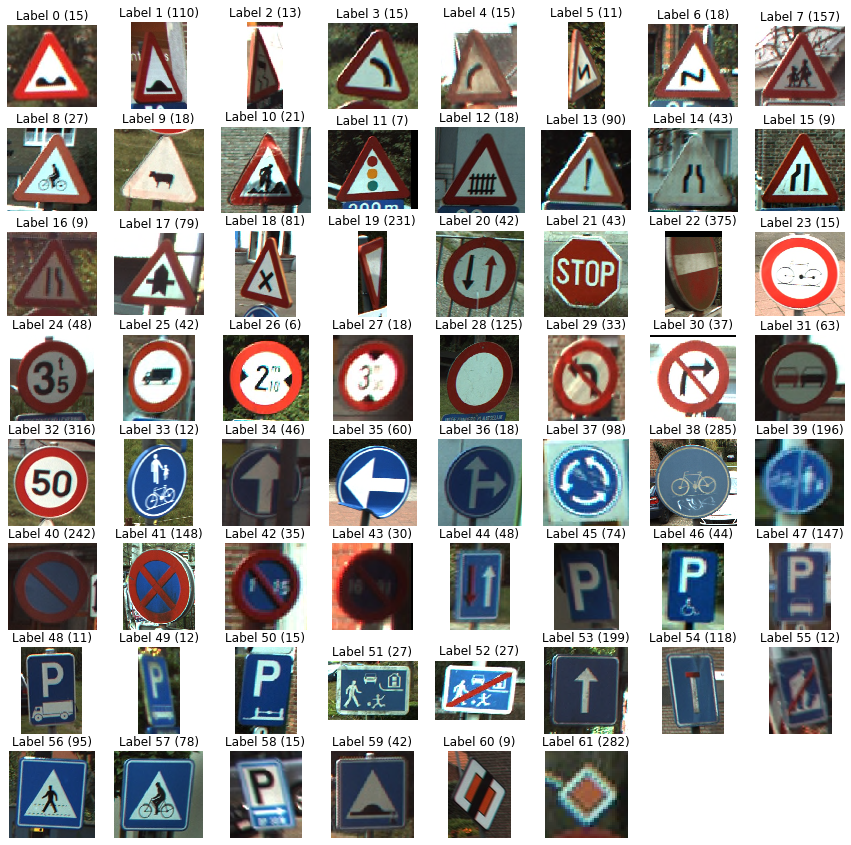

In [9]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

Kijk eens! Dat ziet er goed uit! o te zien hebben we van alle verkeersborden een plaatje dat min of meer het hele beeld vult. Het valt wel op dat de plaatjes niet helemaal vierkant zijn, dat moeten we later wel oplossen. 

Laten we eerst nog eens een type wat meer in detail bekijken. Laten we eens beginnen met type 32.

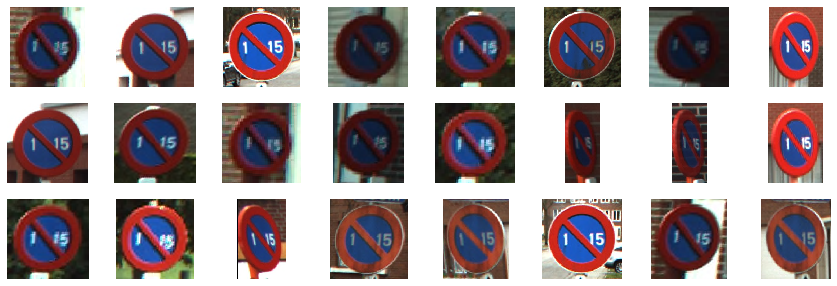

In [10]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 42)

Ahah! Alle snelheidsgeboden vallen in dezelfde klasse. Tensorflow zou daar in principe mee om mee moeten kunnen gaan, maar het is wel goed om dit even gezien te hebben.

Kan je nu zelf andere klasses bekijken? Probeer bijvoorbeeld eens 26 en 27 te bekijken. Wat zou dit straks kunnen betekenen?

## Verschillende formaten
 
Het is over het algemeen handig om de plaatjes in hetzelfde formaat te hebben. We hebben al gezien dat dat in dit geval niet zo is. Een goede manier om dit op te lossen is om de plaatjes handmatig bij te knippen zodat we geen belangrijke delen missen.

Vandaag pakken we het snel aan, dus gaan we voor een hack: We schalen de plaatjes automatisch zonde te knippen. We gooien dus niks weg maar vervormen de beelden dus licht.

Hoe groot zijn de plaatjes?

In [11]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (115, 128, 3), min: 21, max: 255
shape: (128, 63, 3), min: 0, max: 255
shape: (119, 128, 3), min: 0, max: 255
shape: (81, 82, 3), min: 26, max: 255
shape: (98, 105, 3), min: 0, max: 255


Rond de 128 bij 128 dus. Als we ze nou eens allemaal afbeelden op 32x32, dan hebben we minder data (dus sneller resultaat) en ze zijn allemaal van hetzelfde formaat.

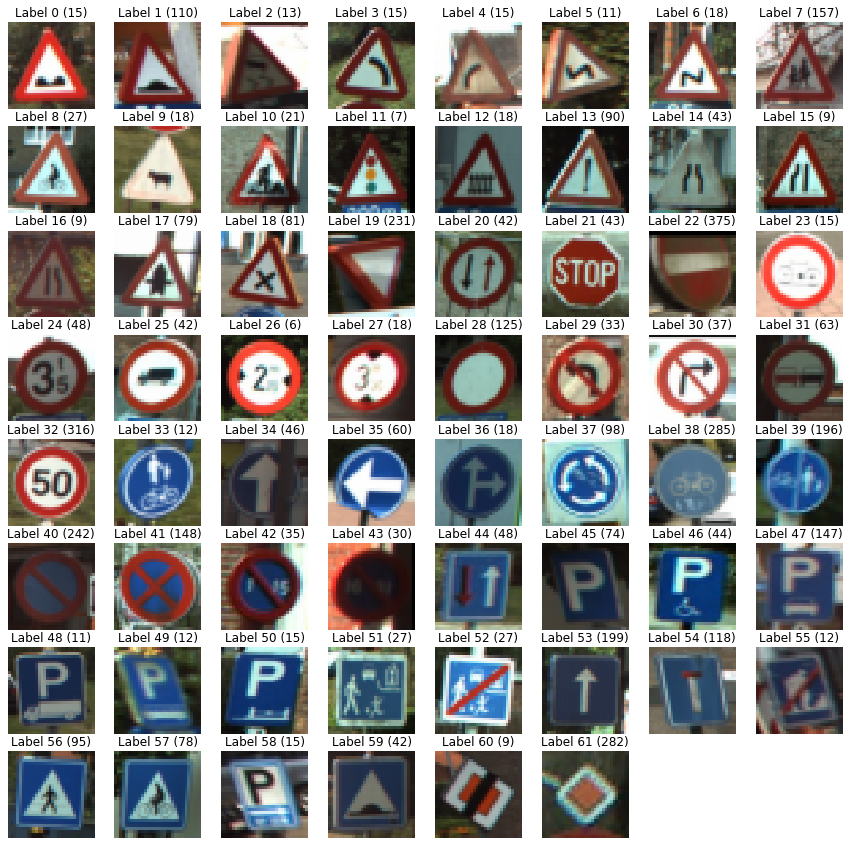

In [12]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32))
                for image in images]
display_images_and_labels(images32, labels)

Minder scherp, maar nog steeds herkenbaar!

# Minimum Viable Model
Nu bouwen we een simpel neuraal netwerk dat plaatjes voor ons gaat classificeren. Het bestaat uit twee input tensors (de plaatjes en de labels), een tussenlaagje dat de plaatjes plat maakt , gevolgd door een fully connected layer die de voorspelling maakt.

Een fully connected layer verbind alle inputs naar elk van zijn eigen nodes. Deze layer heeft er 62 (een voor elke klasse).

In [13]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (4575,) 
images:  (4575, 32, 32, 3)


In [16]:
import warnings
warnings.filterwarnings(action='once')

# Create a graph to hold the model.
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():
    # Placeholders for inputs and labels.
    images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.contrib.layers.flatten(images_ph)

    # Fully connected layer. 
    # Generates logits of size [None, 62]
    logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function. 
    # Cross-entropy is a good choice for classification.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = labels_ph))

    # Create training op.
    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    # And, finally, an initialization op to execute before training.
    # TODO: rename to tf.global_variables_initializer() on TF 0.12.
    init = tf.initialize_all_variables()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'init' type=NoOp>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/datalab/miniconda3/envs/tensorflow-tutorial/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3346, in run_code
    return outflag  File "<ipython-input-15-b6c8a68b4361>", line 31, in <module>
    init = tf.initialize_all_variables()  File "/home/datalab/miniconda3/envs/tensorflow-tutorial/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py", line 193, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs))
images_flat:  Tensor("Flatten/flatten/Reshape:0", shape=(?, 3072), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


## Training
We gaan het model nu 200 keer trainen. (We gebruiken de ADAM optimizer om de cross-entropy zo laag mogelijk te krijgen)

In [18]:
# Create a session to run the graph we created.
session = tf.Session(graph=graph)

# First step is always to initialize all variables. 
# We don't care about the return value, though. It's None.
_ = session.run([init])

print("sessie is aangemaakt!")

sessie is aangemaakt!


In [20]:
for i in range(201):
    _, loss_value = session.run([train, loss], 
                                feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Loss: ", loss_value)
        
print("het model is getraind!")

Loss:  1.5908124
Loss:  1.5802548
Loss:  1.5704267
Loss:  1.5612545
Loss:  1.5526696
Loss:  1.5446146
Loss:  1.537038
Loss:  1.5298954
Loss:  1.5231509
Loss:  1.5167722
Loss:  1.5107284
Loss:  1.5049915
Loss:  1.4995438
Loss:  1.4943635
Loss:  1.4894298
Loss:  1.4847221
Loss:  1.4802258
Loss:  1.4759266
Loss:  1.4718113
Loss:  1.4678701
Loss:  1.4640907
het model is getraind!


## Het model toepassen

Laten we eens kijken welk percentage ons model nu goed heeft.

In [21]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: images32})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(labels, predicted)])
accuracy = match_count / len(labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.678


Alright een percentage rond de 65% procent... klinkt goed!

Hoe ziet dat er dan uit?

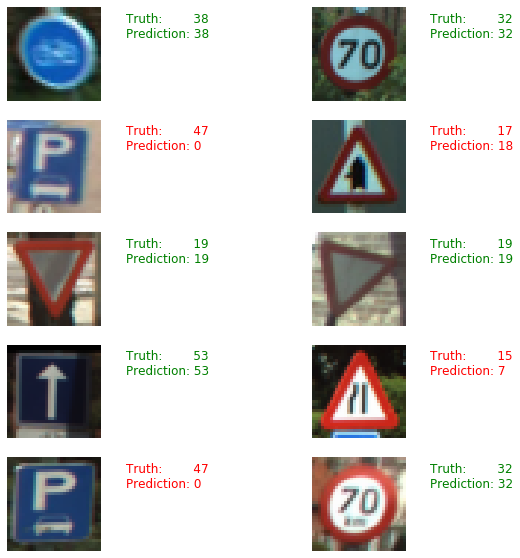

In [22]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]

# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])


## Evaluatie

Het is aardig dat we nu goed scoren op de trainset, maar goed dit model nu ook echt iets geleerd?

Daar hebben we de testset voor, weet je nog?

In [24]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)

print("de testset is ingeladen!")

de testset is ingeladen!


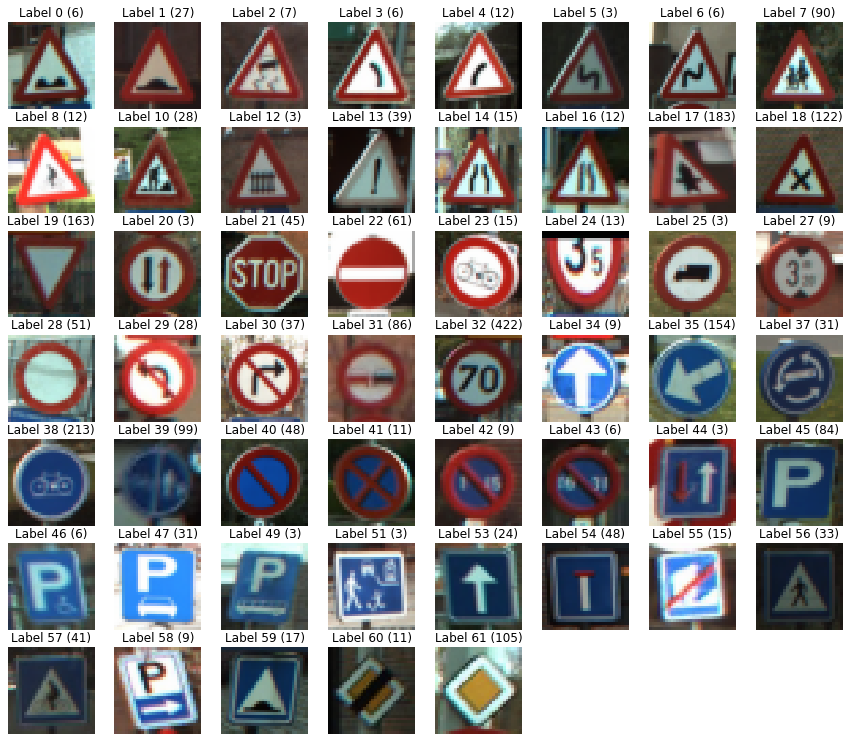

In [25]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32))
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

In [26]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.598


In [28]:
# Close the session. This will destroy the trained model.
session.close()

print("de sessie is weer gesloten!")

de sessie is weer gesloten!
